In [1]:
#data format library
import h5py

#numpy
import numpy as np
import pandas as pd
import numpy.ma as ma
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams["font.family"] = "Times New Roman"
# %matplotlib notebook
import sys
sys.path.append('/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/')
import matplotlib.colors as pltcolors
import os
import copy
import clustering_methods as cl
import operator_calculations as op_calc
import delay_embedding as embed
import stats
import time

np.random.seed(42)

import importlib
importlib.reload(op_calc)

<module 'operator_calculations' from '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/operator_calculations.py'>

In [2]:
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/'
f = h5py.File(path_to_filtered_data+'filtered_jmpool_ex5_kin.h5','r')
lengths = np.array(f['MetaData/lengths_data'],dtype=int)
bouttypes= ma.array(f['bout_types'], dtype=int)
# stims = ma.array(f['stims'])
# ecs = ma.array(f['eye_convergence'])

##shapes are n_fish, max_n_bouts,dim of variable

# bouttypes_allcond= ma.array(f['bout_types'])
# stims_allcond = ma.array(f['stims'])
# ecs_allcond = ma.array(f['eye_convergence'])
time_Bout_allcond = ma.array(f['times_bouts']) #raw times bouts

#shapes are n_fish, max_n_bouts,dim of variable
# X_head_allcond = ma.array(f['head_pos'])
# phi_smooth_allcond = ma.array(f['orientation_smooth'])
# speeds_head_allcond = ma.array(f['speed_head'])
f.close()

In [3]:
time_Bout_allcond[time_Bout_allcond == 0] = ma.masked

In [4]:
condition_labels = ['Light (5x5cm)','Light (1x5cm)','Looming(5x5cm)','ChasingDot coarsespeeds(5x5cm)','ChasingDot finespeeds(5x5cm)','Dark_Transitions(5x5cm)',
                    'Phototaxis','Optomotor Response (1x5cm)','Optokinetic Response (5x5cm)','Dark (5x5cm)','3 min Light<->Dark(5x5cm)',
                    'Prey Capture Param. (2.5x2.5cm)','Prey Capture Param. RW. (2.5x2.5cm)',
                    'Prey Capture Rot.(2.5x2.5cm)','Prey capture Rot. RW. (2.5x2.5cm)','Light RW. (2.5x2.5cm)']

condition_recs = np.array([[515,525],[160,172],[87,148],[43,60],[22,43],[60,87],
                           [202,232],[148,160],[172,202],[505,515],[0,22],
                           [232,301],[347,445],[301,316],[316,347],
                           [445,505]])

In [5]:
conditions = np.zeros((np.max(condition_recs),2),dtype='object')
for k in range(len(condition_recs)):
    t0,tf = condition_recs[k]
    conditions[t0:tf,0] = np.arange(t0,tf)
    conditions[t0:tf,1] = [condition_labels[k] for t in range(t0,tf)]

In [6]:
recs_remove = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/recs_remove.npy')

In [7]:
recs_remove = np.hstack([recs_remove, np.arange(22,60)])

In [8]:
conditions = np.delete(conditions, recs_remove, axis=0)

In [9]:
print(recs_remove)

[ 90 260 264 270 276 352 358 364 375 381 383 392 398 404 410 416 422 427
 433 439 450 456 467 497  22  23  24  25  26  27  28  29  30  31  32  33
  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59]


In [10]:
time_Bout_allcond = np.delete(time_Bout_allcond,recs_remove, axis=0)
time_Bout_allcond[time_Bout_allcond == 0] = ma.masked

In [11]:
## Load symbolic sequences

path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/'
f = h5py.File(path_to_filtered_data + 'kmeans_labels_K5_N1200_s8684.h5')
lengths_all = np.array(f['MetaData/lengths_data'], dtype=int)
labels_fish_allrec = ma.array(f['labels_fish'],dtype=int)
state_trajs = ma.array(f['state_trajs'])
f.close()

# lengths_all = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/lengths_ex2_recordings.npy')
# lengths_all = lengths

In [12]:
# recs_ = np.asarray(conditions[:,0], dtype=int)

to_mask = 1300

# maxL = np.max(lengths_all[recs_])
maxL = np.max(lengths_all)

labels_fish_allrec[labels_fish_allrec == to_mask] = ma.masked

# labels_fishrec = to_mask * ma.ones((len(recs_), maxL))
# labels_fishrec = labels_fish_allrec[recs_,:maxL+2]
# labels_fishrec = np.delete(labels_fishrec,4,0)

# labels_fishrec[labels_fishrec == to_mask] = ma.masked
labels_fish = labels_fish_allrec

# lengths_rem = np.delete(lengths_all, recs_remove)
lengths_rem = lengths_all

In [13]:
## Select Dataset
np.random.seed(42)
seeds = np.random.randint(0,10000,100)
delay_range = np.arange(1,20,1)
dt = 1
div= 463
n_modes=50
labels_all= ma.concatenate(labels_fish,axis=0)
print(labels_fish.shape)

(463, 11651)


In [14]:
P_ensemble = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/P_ensemble_ex8_N1200_s8684.npy')

In [15]:
from scipy.sparse import diags,identity,coo_matrix, csr_matrix
P_ensemble = csr_matrix(P_ensemble)

In [16]:
import msmtools.estimation as msm_estimation
delay = 3
dt = 1
print(delay)
# lcs_ensemble,P_ensemble = op_calc.transition_matrix(labels_all,delay,return_connected=True)
lcs_ensemble = msm_estimation.largest_connected_set(P_ensemble)
inv_measure = op_calc.stationary_distribution(P_ensemble)
final_labels = op_calc.get_connected_labels(labels_all,lcs_ensemble)
R = op_calc.get_reversible_transition_matrix(P_ensemble)
eigvals,eigvecs = op_calc.sorted_spectrum(R,k=10,seed=123)
sorted_indices = np.argsort(eigvals.real)[::-1]
eigvals = eigvals[sorted_indices][1:].real
eigvals[np.abs(eigvals-1)<1e-12] = np.nan
eigvals[eigvals<1e-12] = np.nan
t_imp =  -(delay*dt)/np.log(np.abs(eigvals))
eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
eigfunctions_traj[final_labels.mask] = ma.masked

3


In [17]:
kms = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Results/pool_ex8_PCs/cg4_labels.npy')
kmeans_labels = kms
cluster_traj_all = ma.copy(final_labels)
cluster_traj_all[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj_all[final_labels.mask] = ma.masked

cluster_fish = cluster_traj_all.reshape(labels_fish.shape[0],labels_fish.shape[1])
cluster_fish_mask = cluster_fish.mask

In [18]:
spectral_split = np.load('/Users/gautam.sridhar/Documents/Repos/ZebraBouts/Datasets/Full_Data/spectral_split_g7.npy')

In [19]:
post_f = np.load('/Users/gautam.sridhar/Documents/ZENITH/Figures/posterior_f.npy')

In [21]:
time_Bout_allcond = time_Bout_allcond[:,:maxL,:]

In [22]:
fps = 700.
lifetimessec_fish = [[],[],[],[]]
cond_recs = np.arange(463)
for i,cf in enumerate(cond_recs):
    print(cf)
    time_states = []
    for ms in np.unique(kms):
        sel = cluster_fish[i] == ms
        segments = np.where(np.abs(np.diff(np.concatenate([[False], sel, [False]]))))[0].reshape(-1, 2)
        times = []
        for segment in segments:
            t0,tf = segment
            time_dur = (time_Bout_allcond[i,tf-1][1] - time_Bout_allcond[i,t0][0])/fps
            if time_dur > 0:
                times.append(time_dur)
        lifetimessec_fish[ms].append(times)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [64]:
hr_real = [[],[],[],[]]
real_ciu = [[],[],[],[]]
real_cil = [[],[],[],[]]
for ms in np.unique(kms):
    dwell_times_real = lifetimessec_fish[ms]
    for cf in range(len(dwell_times_real)):
        print(cf)
        if len(dwell_times_real[cf]) == 0:
            hr_real[ms].append(0)
        else:
            m = ma.mean(ma.hstack(dwell_times_real[cf]))
            hr_real[ms].append(m)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [146]:
g = 6
med_gs = [[],[],[],[]]
for k in range(1000):
    cond_recs = np.random.choice(np.arange(463), len(np.arange(463)), p=post_f[:,g])
    for ms in range(4):
        hr_g_ms = np.asarray(hr_real[ms])[cond_recs]
        med_gs[ms].append(ma.median(hr_g_ms))

2.44 2.19 2.57
1.16 1.07 1.19
0.36 0.31 0.37
1.04 1.0 1.29


(0.0, 5.0)

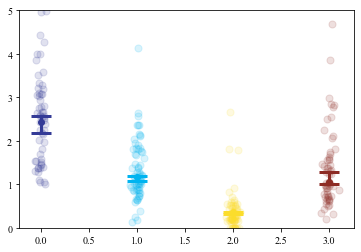

In [147]:
cond_recs = np.where(spectral_split == g)[0]
st_colors = ['#343B97', '#00B4F0', '#FBDD2B', '#8D2B24']
for ms in np.unique(kms):
    plt.scatter(0.03*np.random.randn(np.asarray(hr_real[ms])[cond_recs].shape[0])+ms, np.asarray(hr_real[ms])[cond_recs], s=50, alpha=.15, color=st_colors[ms])
    m = np.median(med_gs[ms],axis=0)
    cil = np.nanpercentile(med_gs[ms],q = 2.5,axis=0)
    ciu = np.nanpercentile(med_gs[ms],q=97.5,axis=0)
    print(round(m,2),round(cil,2),round(ciu,2))
#     plt.scatter(0.03*np.random.randn(np.asarray(med_gs[ms]).shape[0])+ms, np.asarray(med_gs[ms]), s=50, alpha=.15, color=st_colors[ms])
    plt.errorbar(ms, m,[[m-cil], [ciu-m]], fmt='o', elinewidth=3, capsize=10, capthick=3, color=st_colors[ms])
plt.ylim(0,5)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl11/G{}_mean_dt.pdf'.format(g))